In [1]:
import getData
import numpy as np
import pandas as pd
import utils
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy.stats import gaussian_kde, linregress
from datetime import timedelta, date
from calendar import month_abbr
from IPython.display import HTML

In [2]:
# Get rid of code on export


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [3]:
# Get swipetimes data and normalize it
project_time = getData.NewDataSet()
tag_time = getData.NewDataSet('tag')
pt = project_time.get()
tt = tag_time.get()

# now build the superDF containing all the normalized times across the year
sdf = utils.superDF(pt, tt)
sdf.index = pd.to_datetime(sdf.index) # convert to datetime
sdf['month']= pd.DatetimeIndex(sdf.index).month  # Build the month column 

# set date to datetime & build the month column
pt['started'] = pd.to_datetime(pt['started'])
pt['month'] = pd.DatetimeIndex(pt['started']).month

In [4]:
# Fixes in the data

# None activities to Nablabits
none_activities = pt[(pt['project']==28) & (pt['activity'].isnull())]
for i in none_activities.index:
    pt.iloc[i, 4] = 'Nablabits'
    pt.iloc[i, 3] = 50   

In [5]:
# Common settings

# Set default colors
cr = dict(
    sleep = 'tomato',
    opk = 'mediumseagreen',
    bu = 'teal',
    sbox = 'lightgreen',
    sport = 'cadetblue',
    kic = 'indigo',
    
    # These ones are for stacked bars plots (material design)
    bar1 = '#7986cb',  # Indigo 300
    bar2 = '#4db6ac',  # Teal 300
    bar3 = '#cddc39',  # lime 500
    bar4 = '#ffb74d',  # orange 300
    bar5 = '#90a4ae',  # BlueGrey 300
    bar6 = '#ba68c8',  # Purple 300
    bar7 = '#e53935',  # red 600

)

# Section 0)
## Year overview

Notice that BuildUp tag is assigned to several entries inside OpK projects, so therefore there will be duplicated times and it will seem that time tracked is greater. However this is fine, since I show here dedication times rather than how time was equally distrubuted over year. More info in its section.

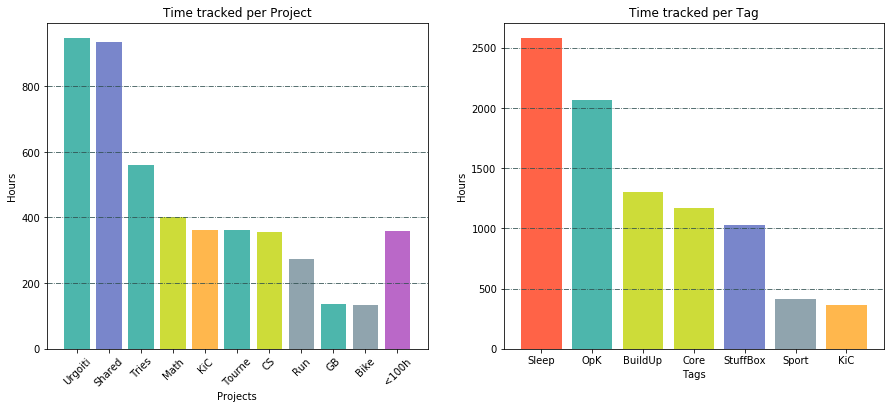

In [6]:
p_outcome = (
    sdf.iloc[:, 0:22].sum().round(2).sort_values(ascending=False))  # The sum by project
t_outcome = (
    sdf.iloc[:, 22:41].sum().round(2).sort_values(ascending=False))  # The sum by tag
p_outcome['lt100h'] = p_outcome[p_outcome.lt(100)].sum()
p_outcome = p_outcome[p_outcome.gt(100)]

# Create figure
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(15, 6))

# Subplot #1, globals by project
ax[0].bar(p_outcome.iloc[1:].index, p_outcome.iloc[1:],
    color=(cr['bar2'], cr['bar1'], cr['bar2'], cr['bar3'], cr['bar4'], cr['bar2'], cr['bar3'],
           cr['bar5'], cr['bar2'], cr['bar5'], cr['bar6'])
)
ax[0].set_xticklabels(
    labels=('Urgoiti', 'Shared', 'Tries', 'Math', 'KiC', 'Tourne', 'CS', 'Run', 'GB', 'Bike', 
     '<100h'),
    rotation=45)
ax[0].grid(axis='y', color='darkslategray', linestyle='-.')
ax[0].set_ylabel('Hours')
ax[0].set_xlabel('Projects')
ax[0].set_title(
    'Time tracked per Project')

# Subplot #2, globals by tag
ax[1].bar(
    ('Sleep', 'OpK', 'BuildUp', 'Core', 'StuffBox', 'Sport', 'KiC', ),
    (t_outcome[0], t_outcome[1], t_outcome[2], t_outcome[3],
     t_outcome[4], t_outcome[8], t_outcome[10],),
    color=(cr['sleep'], cr['bar2'], cr['bar3'], cr['bar3'], cr['bar1'], cr['bar5'], cr['bar4'] ))
ax[1].grid(axis='y', color='darkslategray', linestyle='-.')
ax[1].set_ylabel('Hours')
ax[1].set_xlabel('Tags')
ax[1].set_title(
    'Time tracked per Tag')
plt.show()

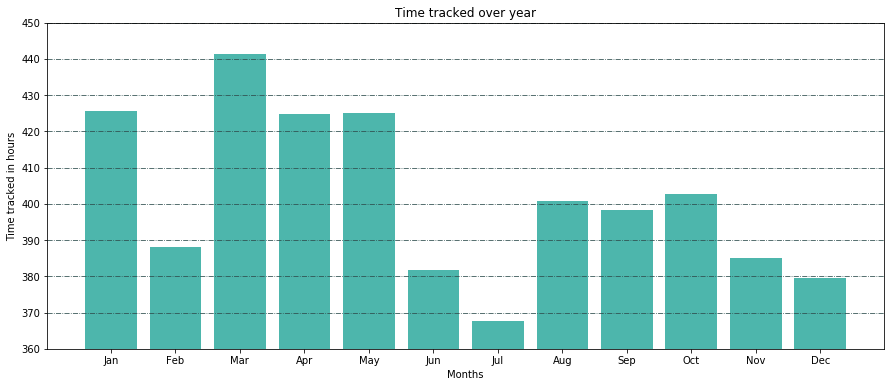

In [7]:
# Time distribution over year
pt_by_month = pt[pt['project'] != 38].groupby('month').sum() / 3600
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(pt_by_month.index, pt_by_month['lenght'], color=cr['bar2'])
ax.set_ybound(360, 450)
utils.set_features(ax, 'Time tracked over year', 'Months', 'Time tracked in hours',)
plt.xticks(pt_by_month.index, month_abbr[1:13])
plt.show()

# Section 1)
## Sleep, awake & untracked time
In this section we'll cover the details between sleep & tracked time and how they have evolutioned over time.

### Some global sleep 

In [8]:
len_pth = pt['lenght'] / 3600
total_sleep = round(sdf['Shift.Sleep'].sum(), 2)
total_sleep_perc = int(total_sleep * 100 / 8760)
over_seven = (pt['project'] == 38) & (len_pth > 7)
over_seven = len_pth[over_seven].sum() * 100 / (total_sleep)

print('Total time slept:          %sh (%s%%)' % (
      total_sleep, total_sleep_perc))
print('Average sleep time:        %sh' % (
      round(sdf['Shift.Sleep'].mean(), 2)))
print('Max time slept in one day: %sh' % (
      round(sdf['Shift.Sleep'].max(), 2)))
print('Over seven percentage:     %s%%' % ( 
      int(over_seven)))

Total time slept:          2580.11h (29%)
Average sleep time:        7.07h
Max time slept in one day: 16.99h
Over seven percentage:     64%


### Global time distribution & time tracked percentage graph
I started out the year tracking a lot of stuff (junk, StuffBox.others, ortu), but that turned out to be useless and exhausting. However, the outcome, didn't get affected so much, finally I tracked the 78% of my awake time.

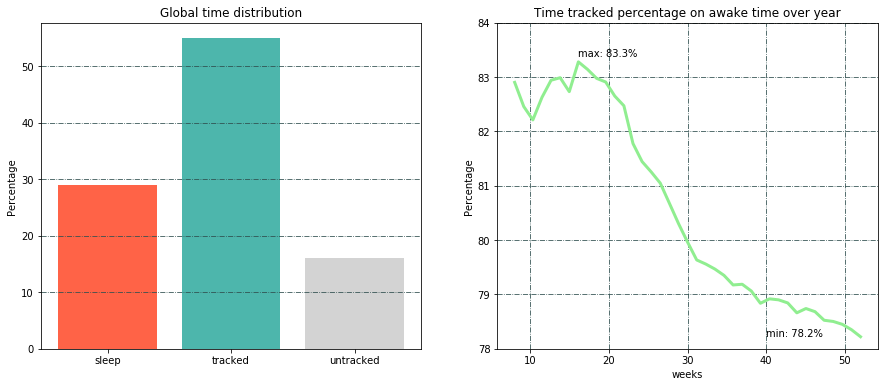

In [9]:
# First, get accumulated time per year
acc_year = np.linspace(24, 24*365, num=365)

# Get accumulated sleep over year (& percentage)
acc_sleep = sdf['Shift.Sleep'].cumsum()
acc_sleep_perc = acc_sleep * 100 / acc_year

# Get accumulated awake time over year
acc_awake = acc_year - sdf['Shift.Sleep'].cumsum()

# Get accumulated tracked time (on awake time) over year
acc_tracked = sdf.iloc[:, 0:22].sum(axis=1).cumsum() - acc_sleep
acc_tracked_perc = acc_tracked * 100 / acc_awake
acc_tracked_perc = acc_tracked_perc[56::8]

# Create figure
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(15, 6))

# Subplot #1, Global time distribution
tracked_perc =  int((len_pth.sum() - total_sleep) * 100 / 8760)
untracked_perc = 100 - total_sleep_perc - tracked_perc
ax[0].bar(('sleep', 'tracked', 'untracked'),
          (total_sleep_perc, tracked_perc, untracked_perc), 
          color=(cr['sleep'], cr['bar2'], 'lightgrey'))
ax[0].set_ylabel('Percentage')
ax[0].set_title('Global time distribution')
ax[0].grid(axis='y', linestyle='-.', color='darkslategray')

# Subplot #2, time tracked percentage over year
ax[1].plot(
    np.linspace(8, 52, 39), acc_tracked_perc, color=cr['sbox'], linewidth=3)
ax[1].set_ylim(78, 84)
ax[1].set_ylabel('Percentage')
ax[1].set_xlabel('weeks')
ax[1].set_title(
    'Time tracked percentage on awake time over year')
ax[1].grid(linestyle='-.', color='darkslategray')

# Some annotations
ymax, ymin = (
    acc_tracked_perc.max(), acc_tracked_perc.min())
ymax_txt = 'max: %s%%' % round(ymax, 1)
ymin_txt = 'min: %s%%' % round(ymin, 1)

ax[1].annotate(
    ymax_txt, xy=(16, ymax), xytext=(16, ymax + .1),)
ax[1].annotate(
    ymin_txt, xy=(16, ymin), xytext=(40, ymin),)


plt.show()

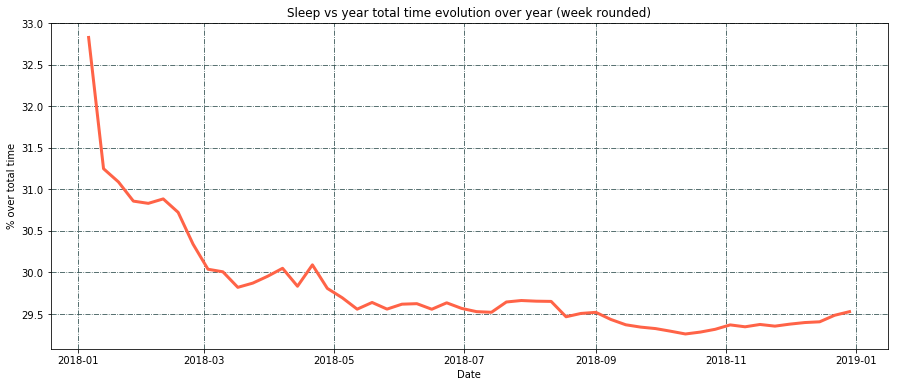

In [10]:
# Evolution of sleep & tracked time
# Create the figure
fig, ax = plt.subplots(figsize=(15, 6))

# Plot #1, sleep vs year's total time
ax.plot(
    acc_sleep_perc.index[5::7], acc_sleep_perc.values[5::7], 
    color=cr['sleep'], linewidth=3)
# ax.set_ylim(29.16, 31.25)
ax.set_xlabel('Date')
ax.set_ylabel('% over total time')
ax.set_title('Sleep vs year total time evolution over year (week rounded)')
ax.grid(linestyle='-.', color='darkslategray')
plt.show()

# BuildUp
BuildUp groups all the projects related to learning (mostly intelectual learning) and growing skills.
There were 4 categories:
* Math
* CS (for computer science)
* Languages, which included french, Deutsch and Japanese
* Other, mainly for asorted readings.

The first two were the *Core,* since the are the main learning focus.

Also I set quality labels to each entry such that:
* Lo: dedicated to passive reading, just read with no other activity. 
* Mid: time that requires some more mental effort than just read (like practicing Duolingo in the bus)
* Hi: practice, create, work out, etc...time involving high amounts of concentration.

In [11]:
# Create awake function
def awake_perc(hours):
    """Return the awake percentage"""
    sleep = sdf['Shift.Sleep'].sum()
    return round(hours * 100 / (8760 - sleep), 2)

# Some quick data
total = sdf.iloc[:, [2, 3, 7, 8, 12, 13]].sum().sum()
avg = sdf.iloc[:, [2, 3, 7, 8, 12, 13]].sum(axis=1).mean()
print('Total time spent: %sh (%s%% of awake time)' %
      (round(total, 2), awake_perc(total)))
print('Average per day: %sh' % round(avg, 2))


Total time spent: 897.41h (14.52% of awake time)
Average per day: 2.46h


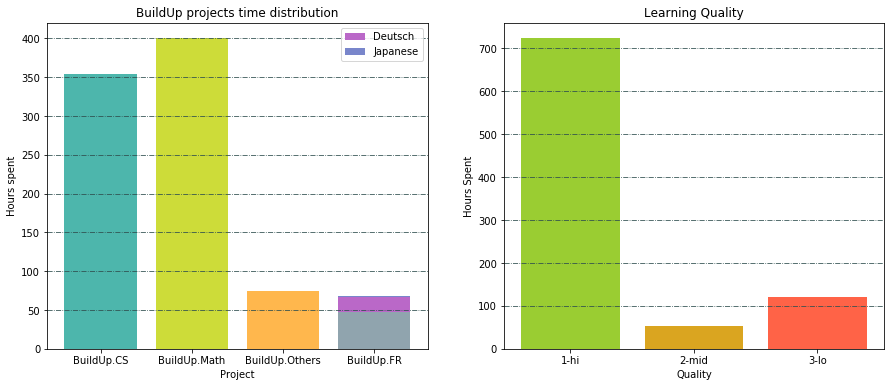

In [12]:
# first define some colors
cr['bu.cs'], cr['bu.math'] = 'teal', 'darkturquoise'
cr['bu.others'], cr['bu.fr'], cr['bu.de'], cr['bu.jap'] = (
    'aquamarine', 'mediumaquamarine', 'seagreen', 'darkslategrey')
bup = sdf.iloc[:, [2, 3, 7, 8, 12, 13]]

# Create the figure
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot#1, Buildup Distribution by projects
base = ax[0].bar(
    bup.sum().iloc[[2, 5, 4, 0]].index, bup.sum().iloc[[2, 5, 4, 0]],
    color=(cr['bar2'], cr['bar3'], cr['bar4'], cr['bar5'], )
)

de = ax[0].bar(
    bup.sum().iloc[[2, 5, 4, 0]].index, [0,0, 0, bup.sum()[1]],
    bottom= + bup.sum()[0], color=cr['bar6'], label='Deutsch'
)
jap = ax[0].bar(
    bup.sum().iloc[[2, 5, 4, 0]].index, [0,0, 0, bup.sum()[3]],
    bottom=bup.sum()[0] + bup.sum()[1], label='Japanese',
    color=cr['bar1']
)
utils.set_features(
    ax[0], 'BuildUp projects time distribution', 'Project', 'Hours spent',)
ax[0].grid(axis='y', linestyle='-.', color='darkslategray')
ax[0].legend()

# Plot#2, Buildup Quality
qlty = sdf.loc[:, ['1-hi', '2-mid', '3-lo']].sum()
ax[1].bar(qlty.index, qlty, color=('yellowgreen', 'goldenrod', 'tomato'))
utils.set_features(ax[1], 'Learning Quality', 'Quality', 'Hours Spent')

plt.show()

## BuildUp Evolution over year

In the begining of the year, it was supposed that buildUp projects would be only: math, CS (computer science), language learning (French, deutsch and Japanese) and other asorted activities which *buildUp* my own self.

But, soon (on march 15th), I came out with projects (inside OpK) which turned out to be BuildUp related and more precisely, with CS, so they were tagged with core tag.

In November, I realized that I could reach with them the 21% of my awake time so I pulled up the dedication to them.

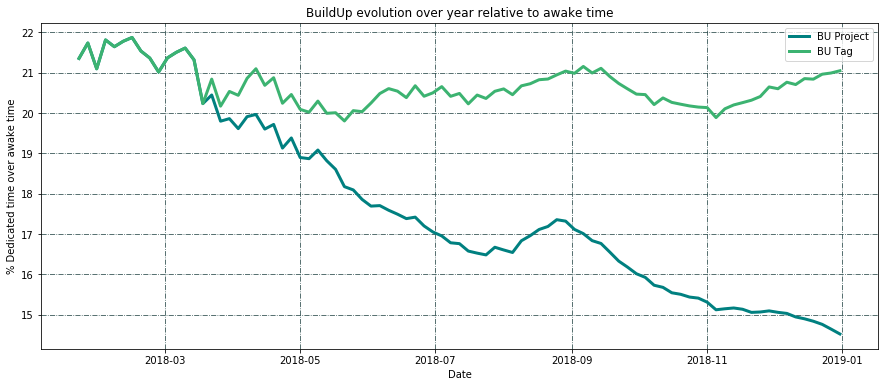

In [13]:
y1 = bup.sum(axis=1).cumsum() * 100 / acc_awake
but = sdf['BuildUp']
y2 = but.cumsum() * 100 / acc_awake
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(
    y1.index[20::4], y1[20::4], color=cr['bu'], linewidth=3, label='BU Project'
)
ax.plot(
    y2.index[20::4], y2[20::4], color=cr['opk'], linewidth=3, label='BU Tag'
)
ax.set_title('BuildUp evolution over year relative to awake time')
ax.set_ylabel('% Dedicated time over awake time')
ax.set_xlabel('Date')
ax.grid(linestyle='-.', color='darkslategray')
ax.legend()

plt.show()

Total BuildUp:   1300.7h (21.05% of awake)
BuildUp average: 3.56h
Max in one day:  10.47h
No Buildup:      20 days


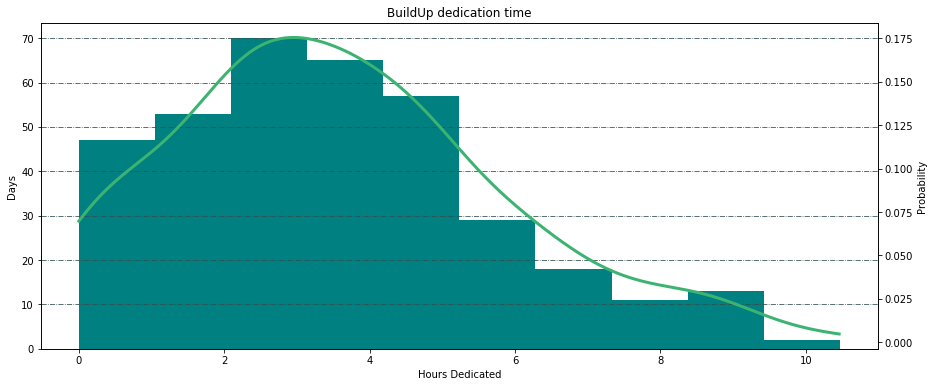

In [14]:
# First, print some useful data
but = sdf['BuildUp']
print('Total BuildUp:   %sh (%s%% of awake)' %
      (round(but.sum(), 2), awake_perc(but.sum())))
print('BuildUp average: %sh' % round(but.mean(), 2))
print('Max in one day:  %sh' % round(but.max(), 2))
print('No Buildup:      %s days' % but[but == 0].count())


# Create the graph
fig, ax = plt.subplots(figsize=(15, 6))

# First plot a binned chart
ax.hist(but, color=cr['bu'])
utils.set_features(ax, 'BuildUp dedication time', 'Hours Dedicated', 'Days',)

# And the probability distribution
ax1 = ax.twinx()
pdf = gaussian_kde(but)
x = np.arange(but.min(), but.max(), 0.01)
ax1.plot(x, pdf(x), color=cr['opk'], linewidth=3)
ax1.set_ylabel('Probability')

plt.show()

## CS over year
CS started out like a project whose goal was something as abstarct as *build my programing skills*, but soon, it became more a category (a tag) for different more focused projects where the main one was TZ-it, a business solution to track orders, production, incomes and expenses for a taylor made clothes business. 

CS project total time:                354.37h
TZ-it project total time:             377.95h
Other OpK projects with impact on CS: 17.38h


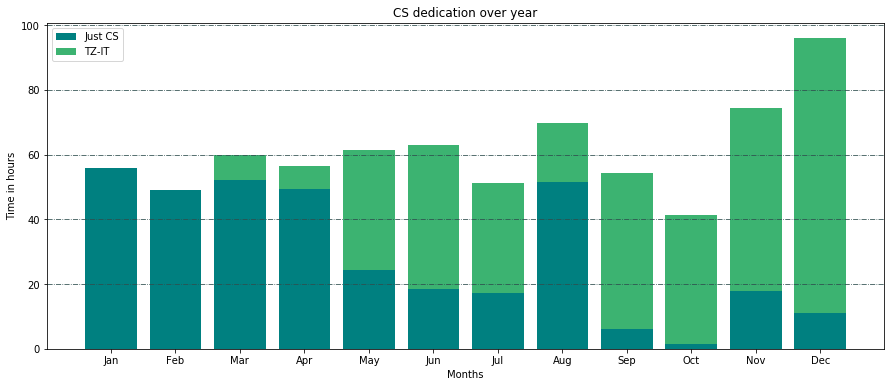

In [15]:
bucs = sdf['BuildUp.CS'].groupby(sdf['month']).sum()

# tz-it project
tzit = pt[pt['activity']=='TZ IT']  # Select tzit project
tzit_core = pd.merge(tt[tt['tag']=='Core'], tzit, on='id',)  # inner join with core tag 
tzit_core = tzit_core.iloc[:, [5, 8]].groupby(tzit_core['month']).sum()  # group by month
tzit_core = tzit_core / 3600  # convert to hours
tzit_core.loc[2], tzit_core.loc[1] = [0], [0]  # add 0 for jan and feb
tzit_core = tzit_core.sort_index()  # Finally sort ascending

# Other OpK projects with incidence over Core tag
opk_tries = pt[pt['name']=='OpK.Tries.2018']  # Select opk tries project
opkt_core = pd.merge(tt[tt['tag']=='Core'], opk_tries, on='id',)  # inner join w/ core tag
diff = round((opkt_core['lenght_x'].sum() / 3600) - tzit_core['lenght_x'].sum(), 2)

print('CS project total time:                %sh' % round(bucs.sum(), 2))
print('TZ-it project total time:             %sh' % round(tzit_core.values.sum(), 2))
print('Other OpK projects with impact on CS: %sh' % diff )


# create the graph
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(bucs.index, bucs, color=cr['bu.cs'], label='Just CS')
ax.bar(bucs.index, tzit_core['lenght_x'], bottom=bucs, color=cr['opk'], label='TZ-IT')

utils.set_features(ax, 'CS dedication over year', 'Months', 'Time in hours',)
ax.legend()
plt.xticks(bucs.index, month_abbr[1:13])
plt.show()

## CS word filter
Since CS was a project itself, we should analyze the details for each entry and assign a main topic for them:
* PnR was one of my first python programs. It let me track my progress when I filled out the daily report, so I knew in which projects I should increase my dedication or in which ones slacken it.
* My first Django project was a journal where I gather the week jot downs, the rate and so on. Also I used it to track the incomes.
* The hotel I worked at needed a redesigned tv welcome screen. I did a web page to cast it onto the tv from the computer.
* Jupyter represents in the begining of the year my first steps with numpy, pandas and notebooks. While to the very end of the year represents the work with *jupyter handbook* reference


[]

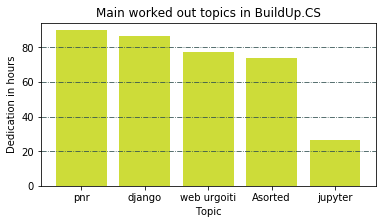

In [16]:
pt['details'] = pt['details'].str.lower()  # set all lowercase
pt['main_topic'] = 'Asorted'  # create main_topic column

# Get all different details
pt_cs = pt[pt['name']=='BuildUp.CS']
details = pd.unique(pt_cs['details'])


# Now set main topics
django = pt_cs[pt_cs['details'].str.contains(
    ('django|incomes|testing queries|static|history|autotime|timeauto|'+
     'dispatcher|cash|migration|view|rest|api|customer|aggregation|form|' +
     'heights'), na=False)]
pt.loc[django.index, 'main_topic'] = 'django'

empty = pt[(pt['name']=='BuildUp.CS') & (pt['main_topic']=='Asorted')]
jupyter = empty[(empty['details'].str.contains('jupyter|pandas|numpy|tensor', na=False))]
pt.loc[jupyter.index, 'main_topic'] = 'jupyter'

empty = pt[(pt['name']=='BuildUp.CS') & (pt['main_topic']=='Asorted')]
splash = empty[empty['details'].str.contains('splash', na=False)]
pt.loc[splash.index, 'main_topic'] = 'web urgoiti'

empty = pt[(pt['name']=='BuildUp.CS') & (pt['main_topic']=='Asorted')]
pnr = empty[(empty['details'].str.contains(
    ('pnr|backup|v3|opk|projects|filter|percents|entries|loop|math|' +
    'division|tracked|graphing|quality|core|project'), na=False))]
pt.loc[pnr.index, 'main_topic'] = 'pnr'


dist = pt_cs['lenght'].groupby(pt['main_topic']).sum() / 3600
dist = dist.sort_values(ascending=False)

# create the graph
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(dist.index, dist, color='#cddc39')
utils.set_features(
    ax, 'Main worked out topics in BuildUp.CS', 'Topic', 'Dedication in hours', )
plt.plot()

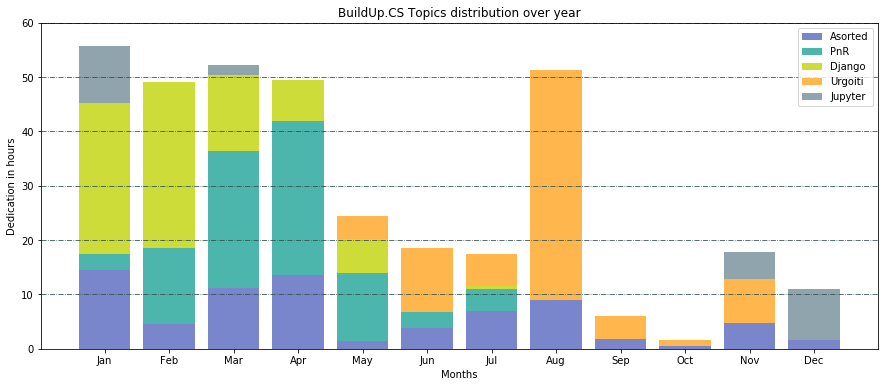

In [17]:
# first, get the data groupped by month
bu_asorted = ((pt['name']=='BuildUp.CS') &  # The asorted filter
             (pt['main_topic']=='Asorted'))
asorted = pt[bu_asorted]['lenght'].groupby(pt['month']).sum() / 3600

pnr = pt[pt['main_topic']=='pnr']['lenght'].groupby(pt['month']).sum() / 3600

django = pt[pt['main_topic']=='django']['lenght'].groupby(pt['month']).sum() / 3600

urgoiti = pt[pt['main_topic']=='web urgoiti']['lenght'].groupby(pt['month']).sum() / 3600


jupyter = pt[pt['main_topic']=='jupyter']['lenght'].groupby(pt['month']).sum() / 3600


# Now the first join
reduced = pd.merge(asorted, pnr, on='month', how='outer', suffixes=('_astd', '_pnr'))


# Iterate to produce the other joins
for df in [django, urgoiti, jupyter]:
    reduced = pd.merge(reduced, df, on='month', how='outer', )

# And change column names so they make sense
reduced = reduced.rename(columns={'lenght_astd': 'Asorted', 
                        'lenght_pnr': 'PnR',
                        'lenght_x': 'Django',
                        'lenght_y': 'Urgoiti',
                        'lenght': 'Jupyter',
                       })
    
# Finally fill with 0 NANs
reduced = reduced.fillna(0)


# Now, create the graph
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(reduced.index, reduced['Asorted'], color=cr['bar1'], label='Asorted')  # Indigo 300
ax.bar(reduced.index, reduced['PnR'], bottom=reduced['Asorted'], 
       color=cr['bar2'], label='PnR')  # teal 300
ax.bar(reduced.index, reduced['Django'], 
       bottom=reduced['Asorted'] + reduced['PnR'], color=cr['bar3'], label='Django')  # lime 500
ax.bar(reduced.index, reduced['Urgoiti'], 
       bottom=reduced['Asorted'] + reduced['PnR'] + reduced['Django'], 
       color=cr['bar4'], label='Urgoiti')  # Orange 300
ax.bar(reduced.index, reduced['Jupyter'], 
       bottom=reduced['Asorted'] + reduced['PnR'] + reduced['Django'] + reduced['Urgoiti'], 
       color=cr['bar5'], label='Jupyter')  # Bluegrey 300
ax.set_ybound(0, 60)
utils.set_features(
    ax, 'BuildUp.CS Topics distribution over year', 'Months', 'Dedication in hours', )

plt.legend()
plt.xticks(reduced.index, month_abbr[1:13])
plt.show()

## Math evolution over year
On may 28th I set the math goal in 400h (I don't know how I came out with this number), so I started to pull up the time dedicated to math. Before coming out with this very number I loosened the intesity on math thinking I should take it easy.

Below graph is a more efficient version of the one I used on PnR project (since it was done with for loops!)

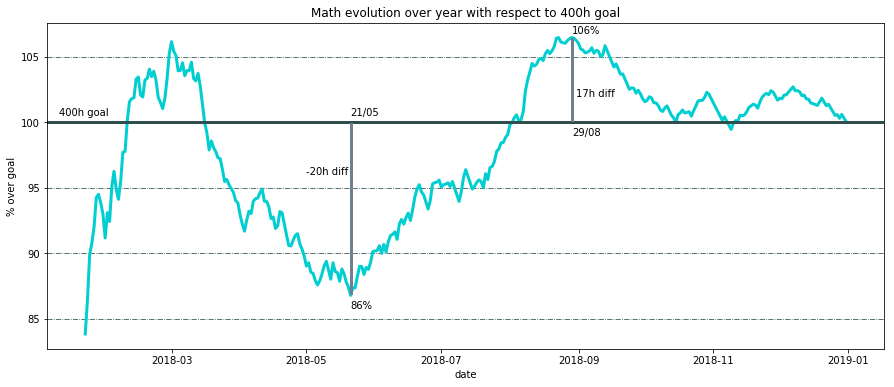

In [18]:
# create the graph
fig, ax = plt.subplots(figsize=(15, 6))

y = bup.iloc[:, [5]].sum(axis=1).cumsum() * 100 / np.linspace(0, 400, 365)
ax.plot(bup.iloc[20:, [5]].index, y[20:], linewidth=3, color=cr['bu.math'],)
ax.axhline(y=100, color='darkslategray', linewidth=3)
utils.set_features(
    ax, 'Math evolution over year with respect to 400h goal', 'date', '% over goal', )

# Show the distance to goal from min value
min_day = y[y==y[30:].min()].index  # Date where the min value  happens
elapsed_days = len(bup[bup.index.date < min_day.date.all()])  # Elapsed days since jan 1st
diff_under = (elapsed_days * (y[30:].min() / 100) - elapsed_days) * 400 / 365  # hour offset
ax.axvline(
    x=min_day, ymin=.17, ymax=.69, linewidth=3, color='slategrey')  # draw a line showing distance
ax.text(min_day, y[30:].min() - 1, '%s%%' % int(y[30:].min()))  # Print the percentage
ax.text(min_day - timedelta(days=20), 96, '%sh diff' % int(diff_under))  # Print offset in hours

# Show the distance from goal on max value
max_day = y[y==y.max()].index  # Date where the max value  happens
elapsed_days = len(bup[bup.index.date < max_day.date.all()])  # Elapsed days since jan 1st
diff_over = (elapsed_days * (y.max() / 100) - elapsed_days) * 400 / 365  # hour offset
ax.axvline(
    x=max_day, ymin=.70, ymax=.95, linewidth=3, color='slategrey')  # draw a line showing distance
ax.text(max_day, y.max() + .3, '%s%%' % int(y.max()))  # Print the percentage
ax.text(max_day + timedelta(days=2), 102, '%sh diff' % int(diff_over))  # Print offset in hours

ax.text(bup.iloc[[8], [5]].index, 100.5, '400h goal', )
ax.text(min_day, 100.5, min_day.date.all().strftime('%d/%m'), )
ax.text(max_day, 99, max_day.date.all().strftime('%d/%m'), )

plt.show()

## Math dedication distribution
Below graph shows the distribution probability for math dedication over year. No math days were excluded to have an idea of the average time I study (when I study).

No math at all days: 87 (~23% of the year)
Study mean:          1.44h
Max:                 4.95h


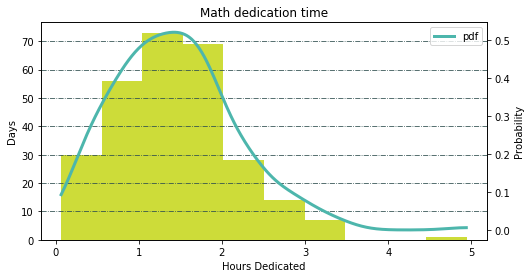

In [19]:
# Create the graph
fig, ax = plt.subplots(figsize=(8, 4))
math_yr = bup.iloc[:, [5]].sum(axis=1)
math = math_yr[math_yr > 0]
print('No math at all days: %s (~%s%% of the year)' %  (
    math_yr[math_yr==0].count(), 
    int(math_yr[math_yr==0].count() * 100 / 365))
     )
print('Study mean:          %sh' % round(math.mean(), 2))
print('Max:                 %sh' % round(math.max(), 2))


# First plot a binned chart
ax.hist(math, color=cr['bar3'], )
utils.set_features(ax, 'Math dedication time', 'Hours Dedicated', 'Days',)

# And the probability distribution
ax1 = ax.twinx()
pdf = gaussian_kde(math)
x = np.arange(math.min(), math.max(), 0.01)
ax1.plot(x, pdf(x), color=cr['bar2'], linewidth=3, label='pdf')
ax1.set_ylabel('Probability')
plt.legend()

plt.show()

## Lang comparative
In 2017 there were 3 languages: French, Deutsch and Japanese.

French activity was in the begining in Duolingo although soon I started with two books: first *chronique d'une morte annoncé* and later *les misérables.* the latter continues on 2019.

Deutsch was active until June mainly as Duolingo practice 

For 2018 I barely dedicated ~1h to japanese (that is not shown on below graph)

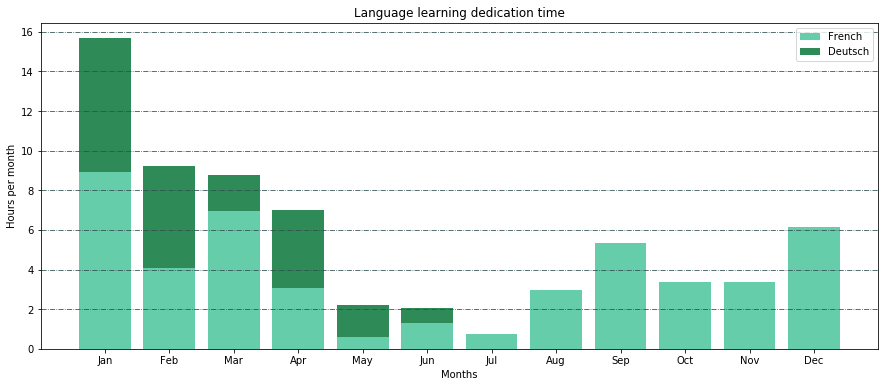

In [20]:
lang = sdf.iloc[:, [2, 3, 41]]
lang = lang.groupby(lang['month']).sum()

# Create the graph    
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(lang.index, lang['BuildUp.FR'], label='French', color=cr['bu.fr'],)
ax.bar(lang.index, lang['BuildUp.DE'], label='Deutsch', color=cr['bu.de'], bottom=lang['BuildUp.FR'])
utils.set_features(ax, 'Language learning dedication time', 'Months', 'Hours per month', )
ax.legend()
plt.xticks(lang.index, month_abbr[1:13])
plt.show()

## Others word filter

Finally the BuildUp.Others project which mainly involves readings on different topics shown below.

Harari makes reference to the two books wrote by Noah Yuval Harari, *Sapiens* & *Homo Deus* which gave me powerful insights. By the end of the year I started *Superintelligence*

[]

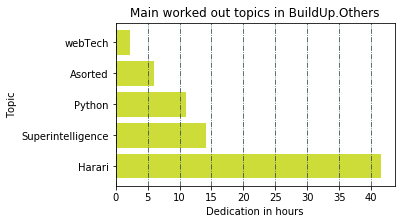

In [21]:
pt_others = pt[pt['name']=='BuildUp.Others']
details = pd.unique(pt_others['details'])

python = pt_others[pt_others['details'].str.contains('python|pandas|django|test dri|hitch|module', na=False)]
pt.loc[python.index, 'main_topic'] = 'Python'

empty = pt[(pt['name']=='BuildUp.Others') & (pt['main_topic']=='Asorted')]
web = empty[empty['details'].str.contains('xhr|react|rest', na=False)]
pt.loc[web.index, 'main_topic'] = 'webTech'

empty = pt[(pt['name']=='BuildUp.Others') & (pt['main_topic']=='Asorted')]
harari = empty[empty['details'].str.contains('harari|homo', na=False)]
pt.loc[harari.index, 'main_topic'] = 'Harari'

empty = pt[(pt['name']=='BuildUp.Others') & (pt['main_topic']=='Asorted')]
sint = empty[empty['details'].str.contains('superint', na=False)]
pt.loc[sint.index, 'main_topic'] = 'Superintelligence'

empty = pt[(pt['name']=='BuildUp.Others') & (pt['main_topic']=='Asorted')]

dist = pt_others['lenght'].groupby(pt['main_topic']).sum() / 3600
dist = dist.sort_values(ascending=False)

# create the graph
fig, ax = plt.subplots(figsize=(5, 3))
ax.barh(dist.index, dist, color='#cddc39')
utils.set_features(
    ax, 'Main worked out topics in BuildUp.Others', 'Dedication in hours', 'Topic', 'x' )

plt.plot()

# OpK
## Year overall view

OpK is the short hand for OpKInRA which stands for *Operation keep the incomes related activities*, that is the actions taken to balance the *cash flow* I need.

Quickly I realized that OpK had two main categories such that, projects with a inmediate income and some other activities (*OpK.Tries*) that could report some revenue (although I didn't claim for it), but whose main value was not the money itself but rather the knowledge, the challenge and the problems solved.

Probably they should be considered more BuildUp than OpK.

Notice that @Urgoiti people spend 1744h per year

OpK dedication:           2069h (33.48% of awake time)
Billable dedication:      1510h (24.44% of awake time)
Tourne vs Urgoiti ratio:  1:2.62 hours


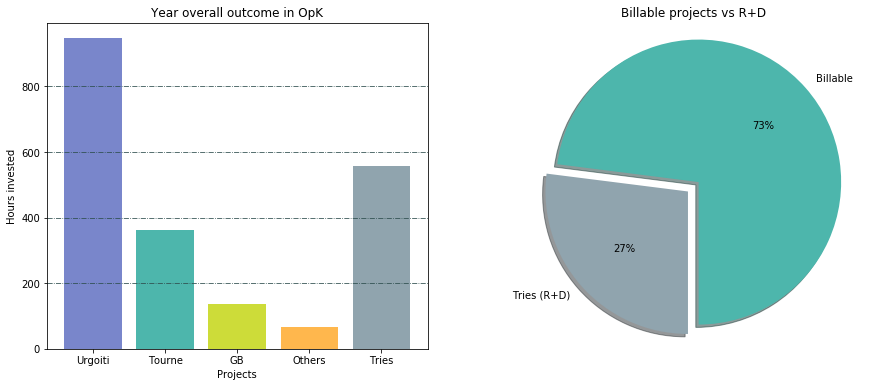

In [22]:
opk = sdf.iloc[:, [19, 15, 5, 18, 11]].groupby(sdf['month']).sum()
totals = opk.sum()
sleep = sdf['Shift.Sleep'].sum()

print('OpK dedication:           %sh (%s%% of awake time)' % (
    int(totals.sum()), 
    round(totals.sum() * 100 / (8760 - sleep), 2)))
print('Billable dedication:      %sh (%s%% of awake time)' % (
    int(totals[:-1].sum()), 
    round(totals[:-1].sum() * 100 / (8760 - sleep), 2)))
print('Tourne vs Urgoiti ratio:  1:%s hours' %
      round(sdf['OpK.Urgoiti.2018'].sum() / sdf['OpK.Tourne.2018'].sum(), 2))

vs = [totals[:-1].sum() *100 / totals.sum(),  # billable percentage over total
      totals[-1] *100 / totals.sum()]  # R+D percentage over total

# Create the graph    
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(15, 6))

# Graph #1, overall outcome
ax[0].bar(totals.index, totals, 
          color=(cr['bar1'], cr['bar2'], cr['bar3'], cr['bar4'], cr['bar5'], ))
ax[0].set_xticklabels(('Urgoiti', 'Tourne', 'GB', 'Others', 'Tries'))
utils.set_features(ax[0], 'Year overall outcome in OpK', 'Projects', 'Hours invested', )

# Graph #2, Billable vs R+D
ax[1].pie(vs, colors=(cr['bar2'], cr['bar5']), shadow=True, explode=(0, .1),
          labels=('Billable', 'Tries (R+D)'), autopct='%1.0f%%', startangle=270)
ax[1].set_title('Billable projects vs R+D')
ax[1].axis('equal')

plt.show()

## Billable activities year breakdown

In Billable activities, by far Urgoiti takes the most of the time. Is a regular source of revenue while Tourne is more concentrated --although it returns roughly as much incomes as the hotel--

The thrid project was GoBasquing, a DMC where I was collaborating (and trying to launch some improvements)

*Others* were mainly tours made with lokafy.

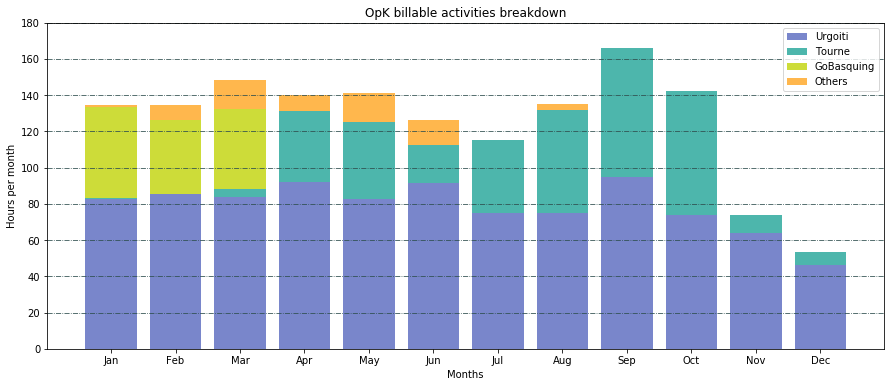

In [23]:
urgoiti, tourne, GB, others, tries = (
    opk['OpK.Urgoiti.2018'], opk['OpK.Tourne.2018'], opk['OpK.GoBasquing.2018'],
    opk['OpK.Others.2018'], opk['OpK.Tries.2018'])

# Create the graph    
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(opk.index, urgoiti, label='Urgoiti', color=cr['bar1'],)
ax.bar(opk.index, tourne, label='Tourne', color=cr['bar2'],
       bottom=urgoiti
      )
ax.bar(opk.index, GB, label='GoBasquing', color=cr['bar3'],
       bottom=urgoiti + tourne
      )
ax.bar(opk.index, others, label='Others', color=cr['bar4'],
       bottom=urgoiti + tourne + GB
      )

utils.set_features(ax, 'OpK billable activities breakdown', 'Months', 'Hours per month', )
ax.legend()
ax.set_ybound(0,180)
plt.xticks(opk.index, month_abbr[1:13])
plt.show()

## OpK.Tries breakdown over year

These were the projects inside OpK across the year, were TZ-IT takes the most part by far.
* Nablabits: in the plan I designed for the year it was suposed that I would start up a freelance career in IT tech sector by the end of the tour season. My idea was to collaborate in a bunch of projects where I could develop a CS career as long as I dove into advanced maths & machine learning, so I started a web page where I could show my skills. However, I eventually dismissed that plan (and now i convinced that it was the smartest idea ever) since Urgoiti gives me the enough calm to focus on the topics I'm learning without worries for the incomes

* For Tourne I designed a self-gididng guide to get by bike to the coast.

* By the last quater of 2018 I joined to my partner business as CTO & account manager where we started using the app I was designing since March.

* In november I design a guide for the hotel where the meeting services offer by them could be shown.

* Also I prepared a proposal for an app, *uLogbook,* for them (that finally was dismissed)

* Micropad was my very first collaboration in an open source project (although it was really awful)

Time spent per project:
tzit         381.87
nablabits     27.00
tourne        54.63
tzm           52.63
ulounges      32.10
ulogbook       6.80
micropad       3.62
dtype: float64


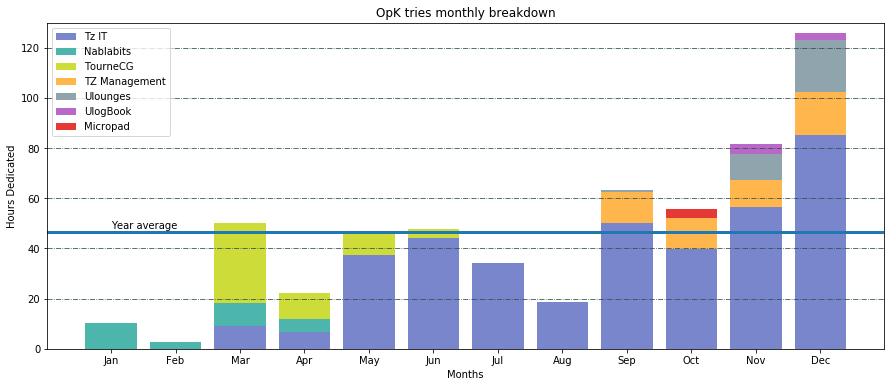

In [24]:
tries = pt[pt['project']==28]

tzit = tries[tries['activity']=='TZ IT']['lenght'].groupby(tries['month']).sum() / 3600
tzit = tzit.rename('tzit')

nablabits = tries[tries['activity']=='Nablabits']['lenght'].groupby(tries['month']).sum() / 3600
nablabits = nablabits.rename('nablabits')

tourne = tries[tries['activity']=='tourneCG']['lenght'].groupby(tries['month']).sum() / 3600
tourne = tourne.rename('tourne')

tzm = tries[tries['activity']=='TZ management']['lenght'].groupby(tries['month']).sum() / 3600
tzm = tzm.rename('tzm')

ulounges = tries[tries['activity']=='urgoiti lounges']['lenght'].groupby(tries['month']).sum() / 3600
ulounges = ulounges.rename('ulounges')

ulogbook = tries[tries['activity']=='urgoiti logbook']['lenght'].groupby(tries['month']).sum() / 3600
ulogbook = ulogbook.rename('ulogbook')

micropad = tries[tries['activity']=='micropad']['lenght'].groupby(tries['month']).sum() / 3600
micropad = micropad.rename('micropad')


triesdf = pd.merge(tzit, nablabits, on='month', how='outer')
triesdf = triesdf.join((tourne, tzm, ulounges, ulogbook, micropad), how='outer', )
    
triesdf = triesdf.fillna(0).sort_index()

print('Time spent per project:')
print(round(triesdf.sum(), 2))

# Now, create the graph
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(triesdf.index, triesdf['tzit'], color=cr['bar1'], label='Tz IT')  
ax.bar(triesdf.index, triesdf['nablabits'], color=cr['bar2'], label='Nablabits',
       bottom = triesdf['tzit'],
      )
ax.bar(triesdf.index, triesdf['tourne'], color=cr['bar3'], label='TourneCG',
       bottom = triesdf['tzit'] + triesdf['nablabits'],
      )
ax.bar(triesdf.index, triesdf['tzm'], color=cr['bar4'], label='TZ Management',
       bottom = triesdf['tzit'] + triesdf['nablabits'] + triesdf['tourne'],
      )
ax.bar(triesdf.index, triesdf['ulounges'], color=cr['bar5'], label='Ulounges',
       bottom = (triesdf['tzit'] + triesdf['nablabits'] + triesdf['tourne'] +
                 triesdf['tzm']),
      )
ax.bar(triesdf.index, triesdf['ulogbook'], color=cr['bar6'], label='UlogBook',
       bottom = (triesdf['tzit'] + triesdf['nablabits'] + triesdf['tourne'] +
                 triesdf['tzm'] + triesdf['ulounges']),
      )
ax.bar(triesdf.index, triesdf['micropad'], color=cr['bar7'], label='Micropad',
       bottom = (triesdf['tzit'] + triesdf['nablabits'] + triesdf['tourne'] +
                 triesdf['tzm'] + triesdf['ulounges'] + triesdf['ulogbook']),
      )
ax.axhline(triesdf.sum().sum() / 12, linewidth=3,)
ax.set_ybound(0, 130)
utils.set_features(ax, 'OpK tries monthly breakdown', 'Months', 'Hours Dedicated',)
ax.text(1, 48, 'Year average')

plt.legend()

plt.xticks(reduced.index, month_abbr[1:13])
plt.show()


## OpK.Tries & Buildup Relationship

OpK and BuildUp are related (maily by OpK.Tries TZ-IT project) so therefore there are hours that are own both by BuildUp and OpK. The following graph shows this detail.

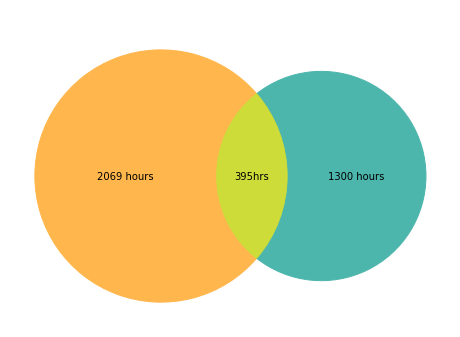

In [25]:
opk_total = sdf['OpK'].sum()
bu_total = sdf['BuildUp'].sum()
bu_opk = pd.merge(
    tt[tt['tag']=='BuildUp'], 
    pt[pt['name'].str.startswith('OpK')], 
    on='id', )
bu_opk_total = round(bu_opk['lenght_x'].sum() / 3600, 2)  # The bu_opk intersection
    
fig, ax = plt.subplots(figsize=(8,8))

plt.title('Opk-Buildup relationship', color='white')
c = venn2(subsets = (opk_total, bu_total, bu_opk_total), set_labels = ('OpK', 'BuildUp'), )

# Edit the texts and colors (change theme to black if possible)
edit = {'10': (cr['bar4'], '2069 hours'),
        '11': (cr['bar3'], '395hrs'),
        '01': (cr['bar2'], '1300 hours')
       }

for k, v in edit.items():
    c.get_patch_by_id(k).set_alpha(1)
    c.get_patch_by_id(k).set_color(v[0])
    c.get_label_by_id(k).set_text(v[1])

# Finally paint in white outside labels
[c.get_label_by_id(i).set_color('white') for i in ('A', 'B')]


plt.show()

## Billable vs BuildUp year evolution over awake time

So, as in many business, there's always a search to balance out *cash flow* with R+D, that is, the gas to keep on running and the long run goals. THe R+D shown down here has a broader scope than just OpK.Tries section displayed before, since it includes al the BuildUp tagged entries against the Billable projects. 

Billable & BuildUp hours and their percentage over awake time
Billable time: 1510h (24.44%)
BuildUp time:  1300h (21.05%)


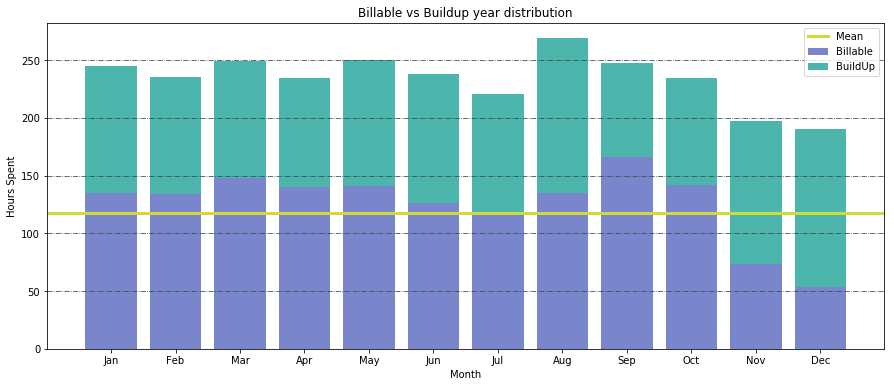

In [26]:
# Comparison between OpK billable projects and BuildUp Tag
comparison = pd.merge(
    sdf.iloc[:, [19, 15, 5, 18, 41]].groupby('month').sum().sum(axis=1).rename('opk'), 
    sdf.iloc[:, [24, 41]].groupby('month').sum(), 
    on='month'
)

mean = (comparison['opk'].mean() + comparison['BuildUp'].mean()) / 2
awake = 8760 - sdf['Shift.Sleep'].sum()

print('Billable & BuildUp hours and their percentage over awake time')
print('Billable time: %sh (%s%%)' % (
    int(comparison.sum()[0]), awake_perc(comparison.sum()[0])))
print('BuildUp time:  %sh (%s%%)' % (
    int(comparison.sum()[1]), awake_perc(comparison.sum()[1])))

# create the graph
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(comparison.index, comparison['opk'], color=cr['bar1'], label='Billable')
ax.bar(comparison.index, comparison['BuildUp'], bottom=comparison['opk'],
       color=cr['bar2'], label='BuildUp')

ax.axhline(mean, linewidth=3, label='Mean', color=cr['bar3'],)
utils.set_features(ax, 'Billable vs Buildup year distribution', 'Month', 'Hours Spent')
plt.legend()
plt.xticks(comparison.index, month_abbr[1:13])
plt.show()


## Tours breakdown
Finally the tour breakdown where it can viewed the tour lenght pd and the distribution over year.

Total tours done:      79 tours (17.36% of the 455 total)
Total time:            294h
Average time per tour: 3.73h
Total tips:            660€
Average tip per tour:  8.35€

### Courses ###
Total courses: 17
Total time:    55.14h
Average time per course: 3.24h (including setup and tear down)


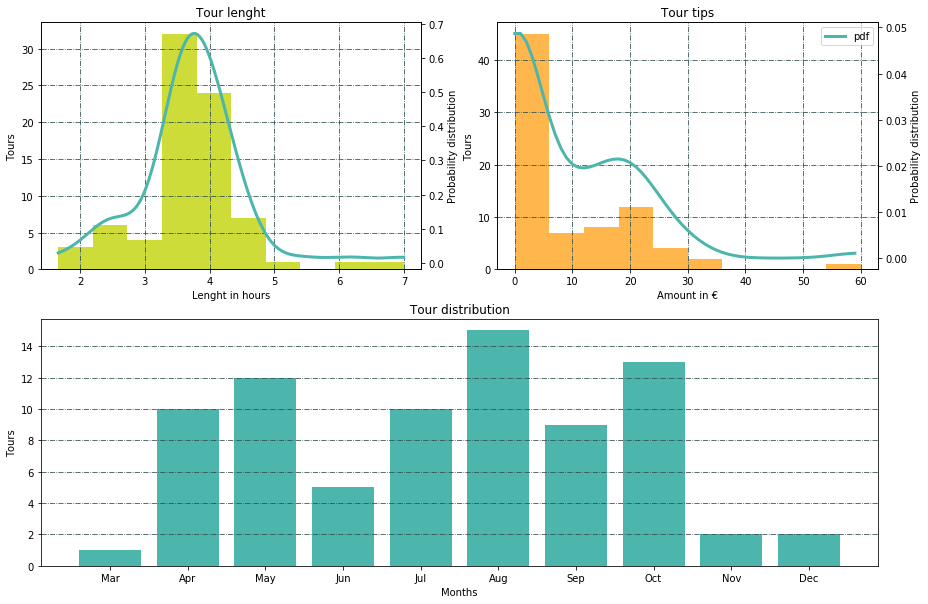

In [27]:
# Set tour id 6788 as cancelled
pt.loc[pt[pt['id'] == 6788].index, 'details'] = 'reu tourne'

# exclude entries with the following words
filter_out = (
    pt['details'].str.contains(
        'details|cancelled|description|imprimir|cursillo|reu tourne|' +
        'course|cursillito|dispo|failed|cusillo|print|analysis|' +
        'management', 
        na=False))

filter_in_courses = (
    pt['details'].str.contains(
        'cursillo|course|cursillito|cusillo', 
        na=False))
filter_out_courses = (
    pt['details'].str.contains(
        'script|review|imprimir', 
        na=False))

# Get courses data
courses = pt[(pt['name'] == 'OpK.Tourne.2018') & (filter_in_courses) & ~(filter_out_courses)]

# Get the tour df and get times
tours = pt[(pt['name'] == 'OpK.Tourne.2018') & ~(filter_out)]
times = tours['lenght'] / 3600

# Process tips
tipsDF = pd.read_csv('tips.csv')
tipsDF['date'] = pd.to_datetime(tipsDF['date'])

# Merge Tours with tips and drop out duplicates
tours_tips = pd.merge(tipsDF, tours, left_on='date', right_on='started', how='inner')
#tours_tips[tours_tips.duplicated(subset='details', keep=False)]  # used to find duplicates
tours_tips = tours_tips.drop([20, 21, 36, 37, 38, 44, 45, 71, 72, 76, 77, 79, 81])


# Print some global numbers
t_done = pt[(pt['name'] == 'OpK.Tourne.2018') & ~(filter_out)]['id'].count()
print('Total tours done:      %s tours (%s%% of the 455 total)' % 
      (t_done, round(t_done * 100 / 455, 2)))
print('Total time:            %sh' % int(times.sum()))
print('Average time per tour: %sh' % round(times.mean(), 2))
print('Total tips:            %s€' % tours_tips['tip'].sum())
print('Average tip per tour:  %s€\n' % round(tours_tips['tip'].mean(), 2))
print('### Courses ###')
print('Total courses: %s' % courses['id'].count())
print('Total time:    %sh' % round(courses['lenght'].sum() / 3600, 2))
print('Average time per course: %sh (including setup and tear down)' %
      round(courses['lenght'].mean() / 3600, 2))

# fig, ax = plt.subplots(2, 2, figsize=(15, 6))
fig = plt.figure(figsize=(15, 10))

ax1 = plt.subplot(221)  # upper left, tour lenght
ax2 = plt.subplot(222)  # upper right, tour tips
ax3 = plt.subplot(212)  # Lower graph, tour distribution

# First plot a binned chart for upper graphs
ax1.hist(times, color=cr['bar3'], )
utils.set_features(ax1, 'Tour lenght', 'Lenght in hours', 'Tours', 'both')
ax2.hist(tours_tips['tip'], color=cr['bar4'], )
utils.set_features(ax2, 'Tour tips', 'Amount in €', 'Tours', 'both')

# the probability distribution for tours
ax1t = ax1.twinx()
pdf = gaussian_kde(times)
x1 = np.arange(times.min(), times.max(), 0.01)
ax1t.plot(x1, pdf(x1), color=cr['bar2'], linewidth=3, label='pdf')
ax1t.set_ylabel('Probability distribution')

# and the probability distribution for tips
ax2t = ax2.twinx()
pdf = gaussian_kde(tours_tips['tip'])
x2 = np.arange(tours_tips['tip'].min(), tours_tips['tip'].max(), 1)
ax2t.plot(x2, pdf(x2), color=cr['bar2'], linewidth=3, label='pdf')
ax2t.set_ylabel('Probability distribution')

# Finally the tour distribution over year
bars = pt[(pt['name'] == 'OpK.Tourne.2018') & ~(filter_out)].groupby('month')['id'].count()
ax3.bar(bars.index, bars, color=cr['bar2'])
ax3.set_xticks(bars.index)
ax3.set_xticklabels(month_abbr[3:13])
utils.set_features(ax3, 'Tour distribution', 'Months', 'Tours',)

plt.legend()
plt.show()

# Sport

Sport mainly involves run & bike (these last one used mainly for displacement, there are a few activities on a mountain bike)

Now I run more than ride (a few years ago was the other way around)

Total sport time: 412h (6.67% of awake time)
Run vs bike ratio: 2.05h
Other sports dedication: 4.2h


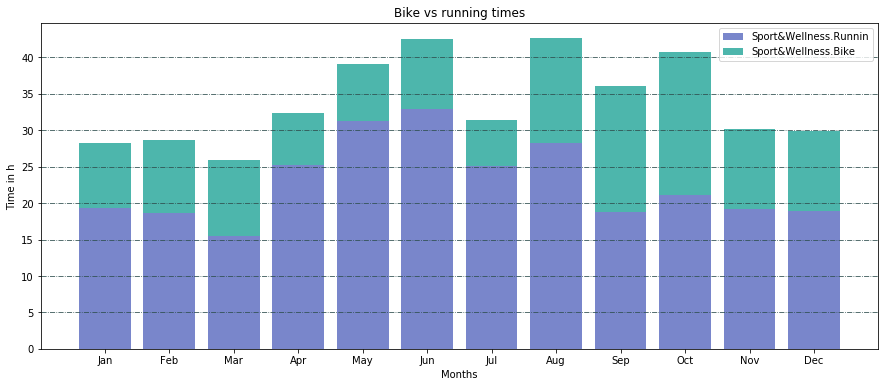

In [28]:
# Bike vs running
# First some quick data
print('Total sport time: %sh (%s%% of awake time)' % 
      (int(sdf['Sport&Wellness'].sum()), awake_perc(sdf['Sport&Wellness'].sum())))
print('Run vs bike ratio: %sh' % 
      round(sdf['Sport&Wellness.Runnin'].sum() / sdf['Sport&Wellness.Bike'].sum(), 2))
print('Other sports dedication: %sh' % round(sdf['Sport&Wellness.Others'].sum(), 2))

# Now a graph
sportDF = sdf.groupby('month').sum()
sportDF = sportDF.loc[:, ['Sport&Wellness.Runnin', 'Sport&Wellness.Bike', ]]
utils.stacked_bar_plot(sportDF, 'Bike vs running times', 'Time in h')

## Running

Total time spent: 412.0h (6.67% of awake time)
Average per day: 1.13h
Distances (total, mean, max): 2414.91km, 17.76km, 65.31km
Times (total, mean, max):     276.66h, 2.03h, 9.25h
Total runs:     136


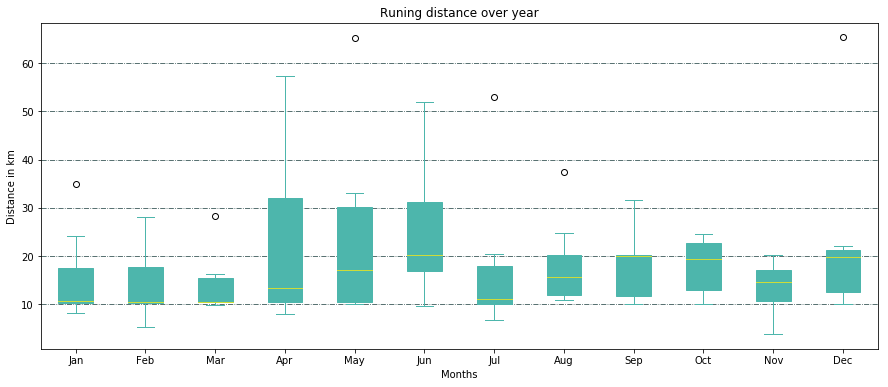

In [29]:
run = pd.read_csv('run.csv')

# Refine dataFrame
run['Fecha'] = pd.to_datetime(run['Fecha'])
run['Hora'] = pd.to_timedelta(run['Hora'])
run['Ritmo medio'] = pd.to_timedelta('0:'+ run['Ritmo medio'])
run['Ganancia de altura'] = (
    pd.to_numeric(run['Ganancia de altura'], errors='coerce').fillna(0))

def sum_to_hours(series):
    """Convert the time delta to hours"""
    return (series.sum().seconds / 3600) + (series.sum().days * 24)
    

# Some quick data
#First, some quick Data
total = sdf['Sport&Wellness'].sum()
avg = sdf['Sport&Wellness'].mean()
print('Total time spent: %sh (%s%% of awake time)' %
      (round(total, 2), awake_perc(total)))
print('Average per day: %sh' % round(avg, 2))
print('Distances (total, mean, max): %skm, %skm, %skm' % (
      round(run['Distancia'].sum(), 2),
      round(run['Distancia'].mean(), 2),
      round(run['Distancia'].max(), 2))
     )
print('Times (total, mean, max):     %sh, %sh, %sh' % (
    round(sum_to_hours(run['Hora']), 2), 
    round(run['Hora'].mean().seconds / 3600, 2),
    round(run['Hora'].max().seconds / 3600, 2),
))
print('Total runs:    ', run['Distancia'].count())

monthly = run.groupby(pd.DatetimeIndex(run['Fecha']).month).sum()
monthly_hours = run.groupby(pd.DatetimeIndex(run['Fecha']).month)['Hora'].sum()
monthly_hours = (
    (pd.TimedeltaIndex(monthly_hours).seconds / 3600) +
    (pd.TimedeltaIndex(monthly_hours).days * 24)
)

# Create a vector list with all the values per month
vectors = list()
for month in range(1, 13):
    vectors.append(
        run[pd.DatetimeIndex(run['Fecha']).month == month]['Distancia'].values)

fig, ax = plt.subplots(figsize=(15, 6))

ax.boxplot(vectors, 
           patch_artist=True,
           medianprops={'color': cr['bar3']},
           boxprops={'color': cr['bar2'], 'facecolor': cr['bar2']},
           whiskerprops={'color': cr['bar2']},
           capprops={'color': cr['bar2']}
          )
ax.set_xticklabels(month_abbr[1:13])
utils.set_features(ax, 'Runing distance over year', 'Months', 'Distance in km',)

plt.show()

### Distance vs height

After ehun Milak (EHM) in July, I realized that height should be as important as distance so I started focusing on the ratio between them and tried to raise it up. From september i ran less but keeping the ratio high (over 42m/km)

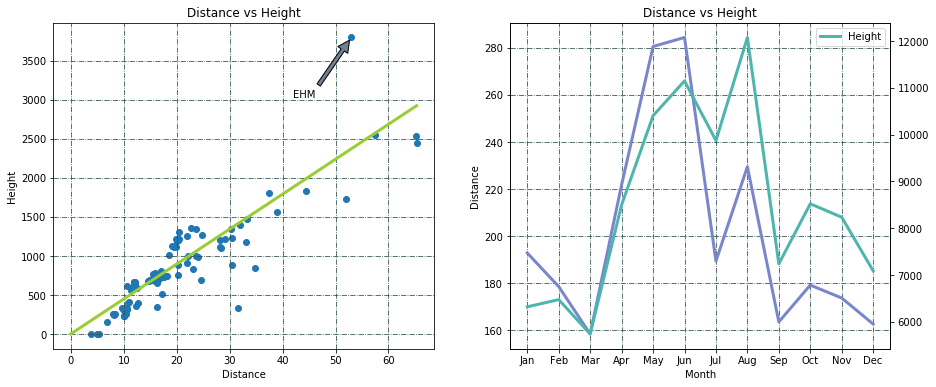

In [30]:

# first get the data grupped by month
run_monthly = run.groupby(pd.DatetimeIndex(run['Fecha']).month)['Distancia'].sum()
height_monthly = run.groupby(pd.DatetimeIndex(run['Fecha']).month)['Ganancia de altura'].sum()

# Create the graph
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(15, 6))

# Graph#1, Correlation between distance and height
ax[0].scatter(run['Distancia'], run['Ganancia de altura'])
best_fit = linregress(run['Distancia'], run['Ganancia de altura'])
x, y = [0, run['Distancia'].max()], [0, best_fit[0] * run['Distancia'].max()]
ax[0].plot(x, y, color='yellowgreen', linewidth=3)
ax[0].annotate('EHM', 
            xy=(run[run['Ganancia de altura'] == run['Ganancia de altura'].max()]['Distancia'],
                run['Ganancia de altura'].max()),
            xytext=(42, 3030),
            arrowprops=dict(facecolor='slategrey', shrink=0.05)
           )
utils.set_features(ax[0], 'Distance vs Height', 'Distance', 'Height', 'both')

# Graph#2, Distance vs height monthly
ax[1].plot(month_abbr[1:13], run_monthly, color=cr['bar1'], linewidth=3, label='Distance')
ax1 = ax[1].twinx()
ax1.plot(month_abbr[1:13], height_monthly, color=cr['bar2'], linewidth=3, label='Height')
utils.set_features(ax[1], 'Distance vs Height', 'Month', 'Distance', 'both')

plt.legend()
plt.show()

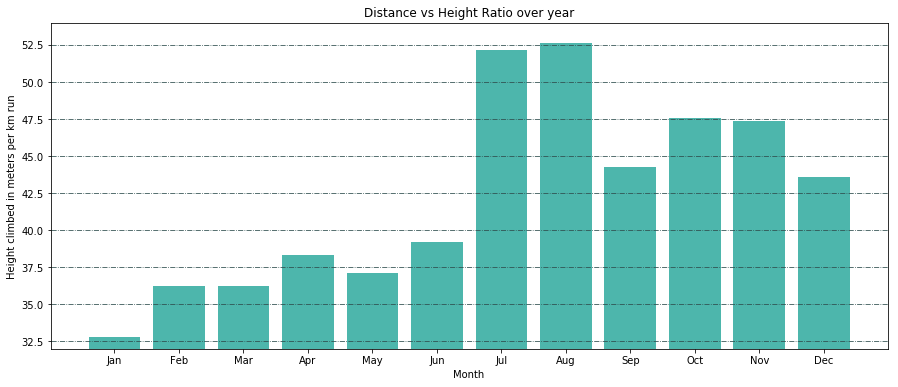

In [31]:
# First, get the data
ratio = (height_monthly / run_monthly)

# Instantiate the graph
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(month_abbr[1:13], ratio, color=cr['bar2'], )
ax.set_ybound(32, 54)
utils.set_features(
    ax, 'Distance vs Height Ratio over year', 'Month', 'Height climbed in meters per km run',)
plt.show()

# StuffBox Section

StuffBox involves all the other activities across the year. As I said in the begining, until may I was tracking a lot of stuff but that turned out to be exahusting, so I focused just in the time shared with my partner to ensure I wasn't forgetting her.

Also, one of the year's goals was the vegetable garden (*Ortu*, in basque), but I quickly dismissed it since I was very bussy and focused in the other projects.

Total time spent: 1026.74h (16.61% of awake time)
Average per day: 2.81h


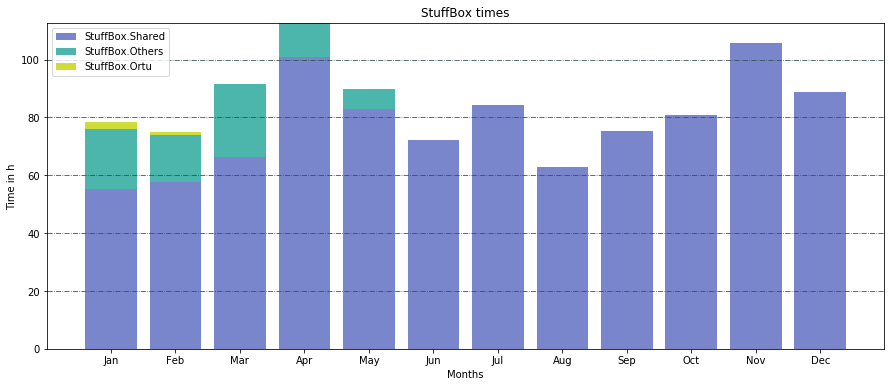

In [32]:
#First, some quick Data
total = sdf['StuffBox'].sum()
avg = sdf['StuffBox'].mean()
print('Total time spent: %sh (%s%% of awake time)' %
      (round(total, 2), awake_perc(total)))
print('Average per day: %sh' % round(avg, 2))

# Now a graph
sb_df = sdf.groupby('month').sum()
sb_df = sb_df.loc[:, ['StuffBox.Shared', 'StuffBox.Others', 'StuffBox.Ortu', ]]
utils.stacked_bar_plot(sb_df, 'StuffBox times', 'Time in h')

# KiC Section

KiC (stands for Keep it Clear) are the planning and summary activities. The main topic is PnR (pause and  recall) which involves writting down in the *moleskine* the daily happens. 

On fridays I perform a kind of cleanup called *KiC debbug*

On mondays I planned the week and recall the previous one.

In the beginning of the year I did previous year summary and set last year's goals. 2017 summary was finished by Jan 16th (not like this year), while 2018 main goals were set by Feb 2nd. 


Total time spent:          363.31h (5.88% of awake time)
Average per day:           1.0h
PnR estimation:           ~225h
Monday recall estimation: ~54h
Summaries estimation:     ~37h


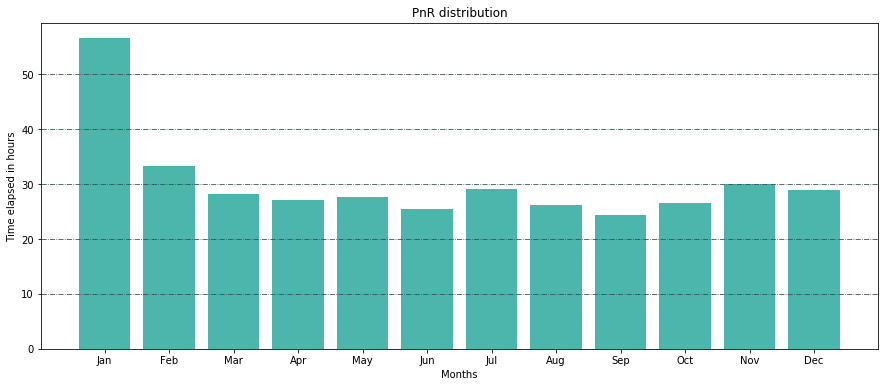

In [33]:
#First, some quick Data
total = sdf['KiC.2018'].sum()
avg = sdf['KiC.2018'].mean()
pnr = pt[(pt['project'] == 25) & (pt['details'].str.contains('pnr'))]
m_recall = pt[(pt['project'] == 25) & (pt['details'].str.contains('recall'))]
summary = pt[(pt['project'] == 25) & 
             ((pt['details'].str.contains('summary')) & 
              ~(pt['details'].str.contains('london|2017|year', na=False)))
            ]

print('Total time spent:          %sh (%s%% of awake time)' %
      (round(total, 2), awake_perc(total)))
print('Average per day:           %sh' % round(avg, 2))
print('PnR estimation:           ~%sh' % int(pnr['lenght'].sum() / 3600))
print('Monday recall estimation: ~%sh' % int(m_recall['lenght'].sum() / 3600))
print('Summaries estimation:     ~%sh' % int(summary['lenght'].sum() / 3600))


fig, ax = plt.subplots(figsize=(15, 6))
bars = sdf.groupby('month')['KiC.2018'].sum()
ax.bar(bars.index, bars, color=cr['bar2'])
ax.set_xticks(bars.index)
ax.set_xticklabels(month_abbr[1:13])
utils.set_features(ax, 'PnR distribution', 'Months', 'Time elapsed in hours',)

plt.show()

## PnR start hour over year

In the begining of the year I did the daily PnR mainly in the evening in order to prepare the following day, however that turned out to be very stressing so by march I started to summary the following day and, eventually, plan the current day.

Some days, due to the hotel or different activities I had to delay the summary until the afternoon.

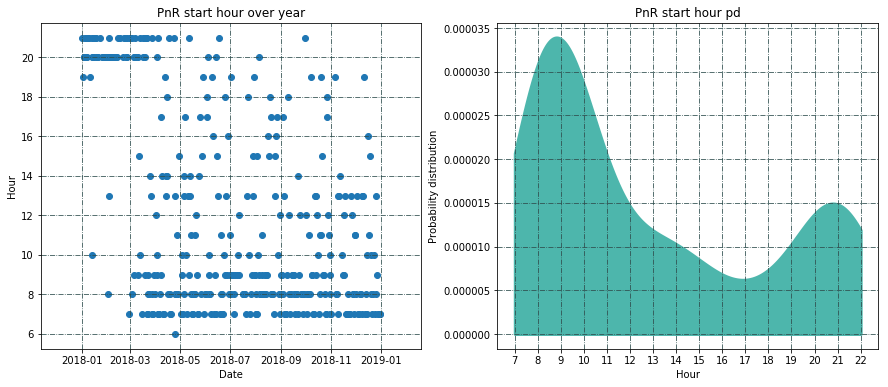

In [34]:
pnr = pt[(pt['project'] == 25) & (pt['details'].str.contains('pnr'))]
m_recall = pt[(pt['project'] == 25) & (pt['details'].str.contains('recall'))]
times = pd.DatetimeIndex(pd.to_datetime(pnr['hour'])).hour
deltas = pd.TimedeltaIndex(pnr['hour']).total_seconds()


# Create the graph
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(15, 6))

# Graph#1, Start hour across the year
ax[0].scatter(pnr['started'], times)
utils.set_features(ax[0], 'PnR start hour over year', 'Date', 'Hour', 'both')

# Graph#2, PnR start PDF
pdf = gaussian_kde(deltas)
x = np.arange(deltas.min(), deltas.max(), 1)
ax[1].fill_between(x, pdf(x), color=cr['bar2'], linewidth=3, label='pdf')
ax[1].set_xticks(np.linspace(deltas.min(), deltas.max(), 16))
ax[1].set_xticklabels(range(7, 23))
utils.set_features(ax[1], 'PnR start hour pd', 'Hour', 'Probability distribution', 'both')

# Finally, show
plt.show()

## Daily Rate
Finally the daily rate. This is my subjective happiness perception. It is supposed that:
    * 1.0 bad day
    * 2.0 flat day
    * 3.0 good day
    * 4.0 Very good day
    * 5.0 Awesome
However, in practice, 2 is bad 2.5 is flat 3 is good and so on.

Year rate average is: 3.69
Day Max rate:         5.0
Day min rate:         2.0


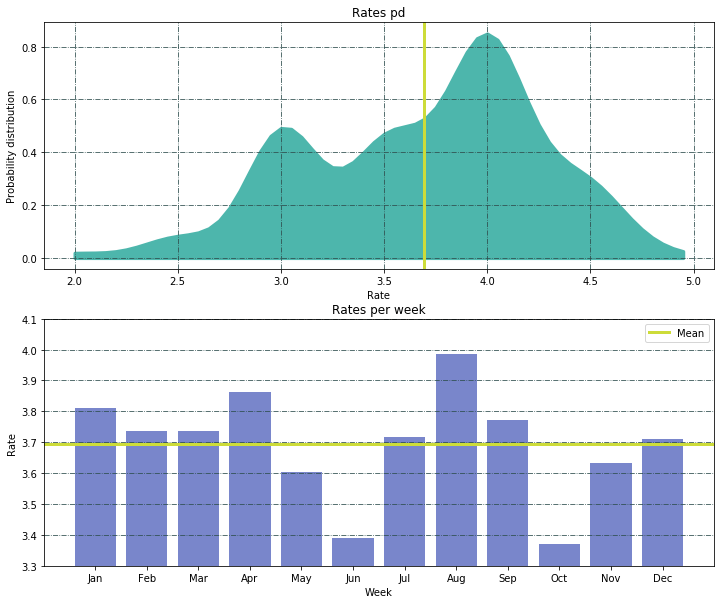

In [35]:
# Enter the dates by hand from paper notebook
jan = [3, 4, 4, 4, 4.5, 4, 3.5, 3.5, 3, 3, 4, 3.5, 3.7, 4.5, 4, 4.5, 4, 4.2, 
       3.8, 3.5, 3, 3.5, 3.8, 4, 3.7, 3.7, 3.5, 4, 4, 4, 4.7]
feb = [4, 4.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 3.5, 3, 3, 3.7, 4.2, 2.5, 3, 4.3,
       4.5, 4, 4.2, 4.1, 3.2, 3, 3.8, 3.5, 3.5, 4.3, 4.4, 4.4, ]
mar = [4, 4.3, 4.3, 4.5, 4.5, 4.5, 4.7, 4.5, 3.7, 3, 3.5, 3.5, 3.1, 3.5,
       3.2, 4.0, 4.0, 2.5, 3.5, 4,3.7, 3, 3, 3, 3, 3, 3.5, 3.9, 4.3, 4.3, 4.3, ]
apr = [4.1, 3, 4.7, 3.5, 4.2, 4.2, 3.7, 3.5, 3.9, 3.8, 3.5, 4.2, 4, 4.5,
       4.1, 3.7, 4.2, 3.5, 3.5, 4, 3, 3,  # These last two are for Bordeaux (no data)
       4, 3.5, 4.5, 4, 4, 4.3, 3.8, 4, ]
may = [3, 3.5, 4.5, 4, 3.6, 3, 3.7, 3, 3.5, 3, 3, 3.2, 3.5, 3.5, 3.5, 4.2,
       2.8, 3.8, 4, 3, 3, 3.8, 4, 4.2, 3.5, 3.8, 3, 4, 4.8, 4.3, 4,]
jun = [4, 2.5, 2.5, 2.5, 2.5, 3, 3, 3.5, 3.8, 3.7, 3.8, 4.1, 4, 3.9, 3.2,
       3, 3.5, 3.5, 3, 3.2, 3.2, 4, 3, 3, 3, 3.8, 4, 4, 3.7, 3.8]
jul = [3.5, 4.2, 4, 4.5, 4, 4, 4.5, 3.9, 4, 4.5, 4.5, 4.5, 2.5, 2.5, 3, 3.8,
       3.5, 3.8, 4, 2.5, 3.2, 3, 3.9, 3, 4.1, 4.5, 4, 3.8, 3.1, 3.9, 3]
aug = [3, 3.7, 4.2, 4.2, 4.3, 4.1, 4, 4.2, 4.2, 4.5, 4, 3.9, 4, 3.5, 3, 4, 4,
       4, 4, 4.2, 3.8, 4, 4.5, 4.1, 4, 4, 4.7, 4, 4, 3, 4.5]
sep = [3.8, 4.5, 3.2, 3.5, 4.1, 4.2, 4, 3, 3, 4.5, 4, 4, 4.2, 4, 3.7, 3, 4.5,
       4, 4, 4, 4, 3.5, 3.5, 4, 4, 4, 3.5, 4, 3.5, 2, ]
ocb = [3, 3, 4.5, 4, 4, 4, 3.5, 4, 3.5, 3, 3.5, 3.5, 3, 2.5, 3, 3.5, 3.5, 2.5,
       3, 3, 4, 3, 4, 4, 4, 4, 2.5, 3, 3.5, 2, 3, ]
nov = [3, 3, 3, 2, 3, 4, 4, 4.5, 5, 4.5, 3, 3, 4, 3, 4, 4, 4, 3, 4, 3, 4.5, 4,
       4, 4.5, 3.5, 3, 3, 4, 4, 3.5, ]
dec = [3.5, 4.5, 3.5, 4.5, 4.5, 4, 4, 3, 4, 3.5, 4, 3.5, 4, 3.5, 4, 4, 3, 4,
       4.5, 3, 3, 3.5, 3.5, 3, 3, 3.5, 4, 4, 3, 4, 4, ]

# Create the Series with a date range for 2018
dates = pd.date_range(start=date(2018, 1, 1), end=date(2018, 12, 31), freq='D')
rates = jan + feb + mar + apr + may + jun + jul + aug + sep + ocb + nov + dec
rate = pd.Series(rates, index=dates)

# Some quick data
print('Year rate average is: %s' % round(rate.mean(), 2))
print('Day Max rate:         %s' % rate.max())
print('Day min rate:         %s' % rate.min())

# Create the graph
fig, ax = plt.subplots(2, 1, sharey=False, figsize=(12, 10))

pdf = gaussian_kde(rate.values)
x = np.arange(rate.min(), rate.max(), .05)
ax[0].fill_between(x, pdf(x), color=cr['bar2'], linewidth=3, label='pdf')
ax[0].axvline(rate.mean(), linewidth=3, label='Mean', color=cr['bar3'],)
utils.set_features(ax[0], 'Rates pd', 'Rate', 'Probability distribution', 'both')

# Group all the rates by week
w_rates = rate.groupby(pd.DatetimeIndex(rate.index).month).mean()
ax[1].bar(w_rates.index, w_rates, color=cr['bar1'])
ax[1].set_xticks(w_rates.index)
ax[1].set_xticklabels(month_abbr[1:13])
ax[1].set_ybound(3.3, 4.1)
ax[1].axhline(rate.mean(), linewidth=3, label='Mean', color=cr['bar3'],)
utils.set_features(ax[1], 'Rates per week', 'Week', 'Rate',)


# Finally, show
plt.legend()
plt.show()